In [16]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import tensorflow as tf
import dataset
import IPython.display as ipd

import importlib

In [ ]:
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128

In [9]:
file = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/19-198-0003.flac'
mono, native_sr = sf.read(file)
if native_sr != sample_rate:
    mono = librosa.resample(mono, native_sr, sample_rate)

In [10]:
# Standarad Spectrogram

spec = librosa.stft(mono, n_fft=n_fft, hop_length=fft_hop, window='hann')
spec.shape

(513, 991)

In [19]:
# Constant Q Transform

cqt = librosa.cqt(mono, sr=sample_rate)#, hop_length=fft_hop, n_bins=257, bins_per_octave=36)
cqt.shape

(84, 496)

In [20]:
# ICQT
new_mono = librosa.icqt(cqt, sr=sample_rate)#, hop_length=fft_hop, bins_per_octave=36)

C:\Program Files\Anaconda3\lib\site-packages\librosa\core\constantq.py:615: UserWarning: librosa.icqt is unstable, and subject to change in future versions. Please use with caution.
  warnings.warn('librosa.icqt is unstable, and subject to change in future versions. '
C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2207: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[s

In [21]:
print(mono.shape)
print(new_mono.shape)

(253625,)
(253440,)


In [22]:
ipd.Audio(mono, rate=sample_rate)

In [23]:
ipd.Audio(new_mono, rate=sample_rate)

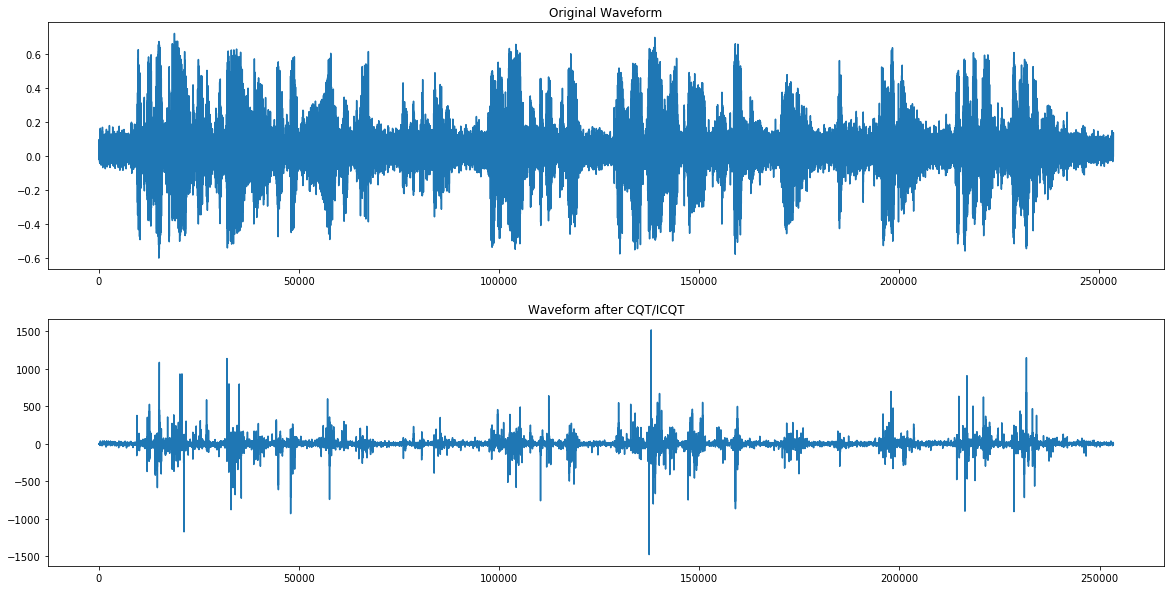

In [29]:
x1 = range(mono.shape[0])
x2 = range(new_mono.shape[0])
fig, ax = plt.subplots(2, 1, figsize=(20,10))

ax[0].plot(x1, mono)
ax[0].set_title('Original Waveform')
ax[1].plot(x2, new_mono)
ax[1].set_title('Waveform after CQT/ICQT')

In [ ]:
np.abs(cqt).min()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(np.abs(spec))

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(np.abs(cqt))

In [2]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
representation = 'constant q'

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '134/134-6'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  representation,
                                  mag_phase)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [3]:
sess = tf.Session()
sample = sess.run(mixed_mag)

In [ ]:
importlib.reload(dataset)

In [ ]:
type(representation)

In [6]:
sample.shape

(5, 256, 256, 1)

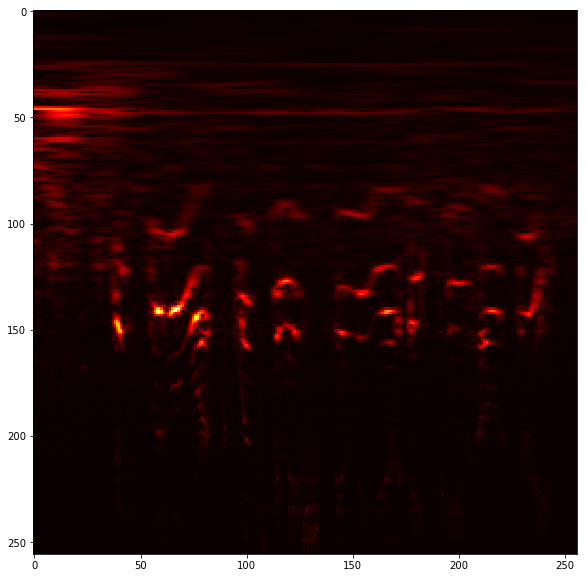

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(np.abs(sample[0,:,:,0].T))